# Analyse d'incertitudes

In [ ]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats
import pandas as pd

bd.projects.set_current('2025-06-10_ecoinvent_311')
eidb = bd.Database('ecoinvent-3.11-cutoff')
biodb = bd.Database('ecoinvent-3.11-biosphere')
fgdb = bd.Database('betons_armes')

beton_A = fgdb.search("Béton A")[0]
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]]
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0]

### ACV statique vs ACV stochastique

Nous commençons par réaliser une ACV de béton A prenant en compte les incertitudes sur les valeurs des flux élémentaires et intermédiaires, données par ecoinvent (sur les coefficients des matrices A et B) et sur les facteurs de caractérisation (coefficients de la matrice C). Pour commencer au plus simple, nous nous contentons de faire le calcul uniquement sur l'indicateur de potentiel de réchauffement climatique à 100 ans.

Nous réalisons peu de lancers de Monte-Carlo (200) par économie de temps. 

In [27]:
n_MC = 400
lca_unc = bc.LCA(demand={beton_A.id : 1.0},method=gwp100,use_distributions=True) # L'argument use_distribution=True indique de préparer les matrices pour des tirages aléatoires
lca_unc.lci()
lca_unc.lcia()

scores = [lca_unc.score for _ in zip(lca_unc,range(n_MC))]

In [28]:
scores # On obtient une liste de résultats

[641.3829055200634,
 611.6432333920441,
 546.3661790575776,
 618.133744788776,
 643.9153588613676,
 597.9220647883496,
 654.2096807221086,
 593.9658645682575,
 694.0960725203012,
 571.8587008869662,
 534.4503158969966,
 593.69914285717,
 544.8064846023271,
 529.6880390908889,
 626.8836676444907,
 587.0837084540335,
 589.3624186391212,
 569.3122604363614,
 562.7853869572837,
 596.6775264307822,
 776.5386649257777,
 661.2001801557301,
 558.2656919774065,
 702.775939658002,
 581.9666192043458,
 718.4721555322085,
 732.480859239799,
 528.8734491525172,
 626.1451720532214,
 560.0554737780952,
 583.6452025003454,
 563.6947075127315,
 479.28960482266507,
 723.5919477641885,
 578.5911394862692,
 718.9210413371077,
 673.5544978748916,
 693.2175588698533,
 452.6025593291943,
 682.1458833150009,
 645.6328482601162,
 504.7574206539302,
 629.9482697053369,
 630.6313597004975,
 703.8943128435413,
 623.965234874056,
 575.2414497847842,
 559.5623163998315,
 608.1022053499611,
 549.4203948234477,
 582.

In [53]:
import numpy as np
scores_mean = np.mean(scores)
scores_med = np.median(scores)
print('moyenne : ',scores_mean,'médiane : ',scores_med)

moyenne :  614.0707336693425 médiane :  602.3924960203867


On peut calculer le score d'impact par ACV sans tirage aléatoire, afin de comparer les scores.

In [54]:
lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)
lca.lci()
lca.lcia()

s = lca.score

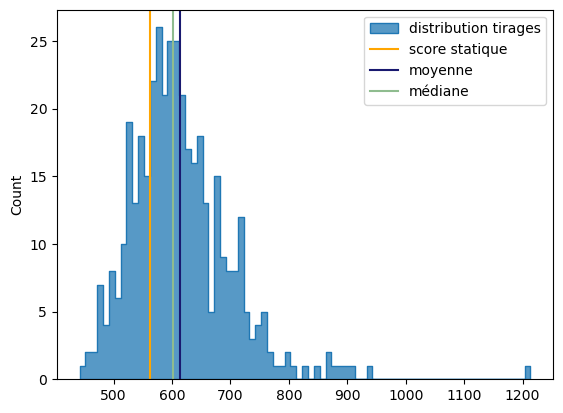

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(scores,binwidth=10,element='step',label = "distribution tirages",legend=True) # Tracé de la distribution
ax.axvline(x=s, color='orange',label = 'score statique') # Tracé d'une ligne verticale à la valeur en calcul statique
ax.axvline(x=scores_mean, color='midnightblue',label = 'moyenne') # Tracé à la moyenne des tirages
ax.axvline(x=scores_med, color='darkseagreen',label = 'médiane') # Tracé à la médiane des tirages
ax.legend(loc='upper right')


On remarque un décalage non négligeable entre le score sans tirage et la moyenne des tirages. Pourquoi ?

In [ ]:
exchanges = [exc.input.exchanges() for exc in beton_A.technosphere()]
uncertainty_types = [[e.uncertainty['uncertainty type'] for e in exc] for exc in exchanges]
uncertainty_types # 0 veut dire que l'incertitude n'est pas renseignée, 2 que la distribution est lognormale :

Cela vient d'un grand nombre d'incertitudes d'ecoinvent qui suivent une loi lognormale, choisie pour de multiples raisons,  notamment pour éviter les valeurs négatives. Pour creuser ce sujet, vous pouvez lire [ce billet](https://chris.mutel.org/ecoinvent-lognormal.html) de Chris Mutel et [cet article](https://link.springer.com/article/10.1007/s11367-013-0670-5) de Ciroth et al.

### Comparaison sous incertitudes

dépendantes, indépendantes

indice de discernabilité